#References

In [ ]:
#[1] https://www.kaggle.com/code/alexalex02/semantic-segmentation-of-aerial-images
#[2] https://github.com/qubvel/segmentation_models.pytorch/issues/327
#[3] https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb
#[4] https://smp.readthedocs.io/_/downloads/en/latest/pdf/
#[5] https://github.com/qubvel/segmentation_models.pytorch/issues/692
#[6] https://github.com/qubvel/segmentation_models.pytorch/issues/147

#Setup

##gDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/MyDrive/School/M_Eng/Research/Bennett_Datasets/uavid_mini/data' '/content'

##Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
#upload kaggle token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bennettnewhook","key":"116df93c3e5495f24c1384cc3e581d5d"}'}

In [ ]:
!mkdir ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!rm -rf kaggle.json

In [ ]:
#NOTE: this is the smaller of the 2 kaggle versions of uavid (4.36GB vs 12.58GB)

!kaggle datasets download -d titan15555/uavid-semantic-segmentation-dataset

100% 3.68G/3.69G [00:41<00:00, 95.0MB/s]
100% 3.69G/3.69G [00:41<00:00, 94.5MB/s]


In [ ]:
!unzip uavid-semantic-segmentation-dataset.zip -d data

In [ ]:
!rm -rf /content/uavid-semantic-segmentation-dataset.zip

##Packages

In [ ]:
!pip install torch
!pip install segmentation-models-pytorch==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.5 MB/s 
     |████████████████████████████████| 376 kB 24.2 MB/s 
     |████████████████████████████████| 58 kB 8.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12422 sha256=df16253409e348b958e36c158d8a6371e15d7088ca6d5c874d1e5989c43f5bf1
  Stored in directory: /root/.cache/pip/wheels/6b/48/d7/9a3ea4072e0d735f895d5e58f9a679903dcb4e90a55418955b
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=d383633da1687f9077f1c968ad17991c76155736e600b9aed7a17cca835fb326
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels


#Data

##Overview

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

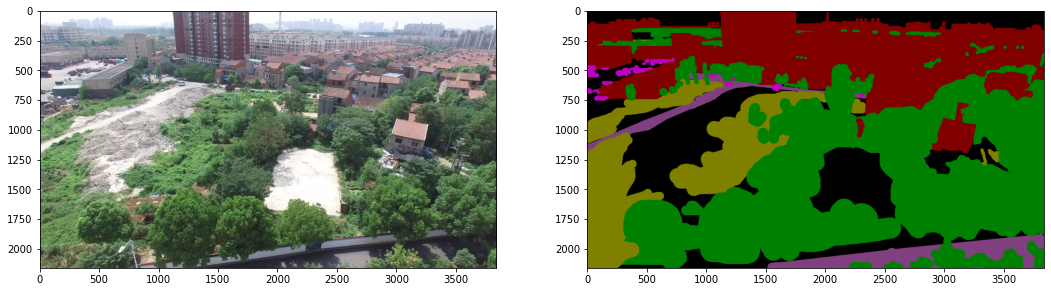

In [ ]:
#[1]
def example(image_path = './data/train/train/seq1/Images/000900009.png',
             mask_path ='./data/train/train/seq1/Labels/000900009.png'):
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    plt.figure(figsize=(18, 24))
    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
example()

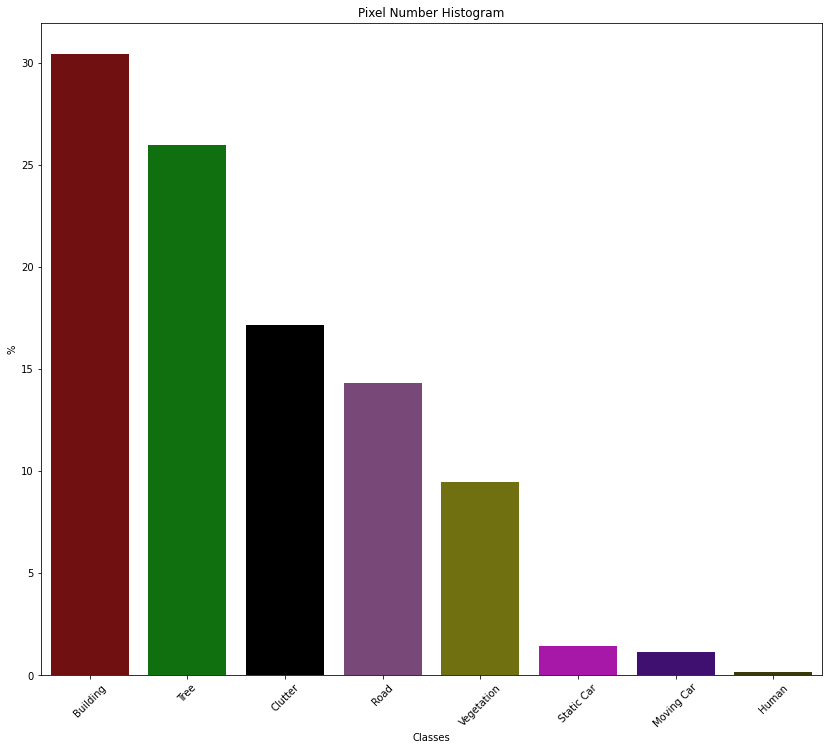

In [ ]:
#[1]
import pandas as pd
import seaborn as sns
cls = ['Building', 'Tree', 'Clutter', 'Road', 'Vegetation', 'Static Car', 'Moving Car', 'Human']
pixels = [30.436, 25.977, 17.120, 14.322, 9.464, 1.405, 1.115, 0.162]
pix = pd.DataFrame({'Classes': cls, 'Pixel Number': pixels})

def plot_pixel():
    plt.figure(figsize=(14,12))
    sns.set_palette(['#800000','#008000','#000000', '#804080', '#808000', '#C000C0', '#400080', '#404000'])
    sns.barplot(x='Classes', y='Pixel Number', data=pix)
    plt.title('Pixel Number Histogram')
    plt.ylabel('%')
    plt.xticks(rotation=45)

plot_pixel()

##Preparation

In [ ]:
#[1]
import numpy as np

class UAVidColorTransformer:
    def __init__(self):
    # color table.
        self.clr_tab = self.createColorTable()
    # id table.
        id_tab = {}
        for k, v in self.clr_tab.items():
            id_tab[k] = self.clr2id(v)
        self.id_tab = id_tab

    def createColorTable(self):
        clr_tab = {}
        clr_tab['Clutter'] = [0, 0, 0]
        clr_tab['Building'] = [128, 0, 0]
        clr_tab['Road'] = [128, 64, 128]
        clr_tab['Static_Car'] = [192, 0, 192]
        clr_tab['Tree'] = [0, 128, 0]
        clr_tab['Vegetation'] = [128, 128, 0]
        clr_tab['Human'] = [64, 64, 0]
        clr_tab['Moving_Car'] = [64, 0, 128]
        return clr_tab

    def colorTable(self):
        return self.clr_tab

    def clr2id(self, clr):
        return clr[0]+clr[1]*255+clr[2]*255*255

  #transform to uint8 integer label
    def transform(self,label, dtype=np.int32):
        height,width = label.shape[:2]
    # default value is index of clutter.
        newLabel = np.zeros((height, width), dtype=dtype)
        id_label = label.astype(np.int64)
        id_label = id_label[:,:,0]+id_label[:,:,1]*255+id_label[:,:,2]*255*255
        for tid,val in enumerate(self.id_tab.values()):
            mask = (id_label == val)
            newLabel[mask] = tid
        return newLabel

  #transform back to 3 channels uint8 label
    def inverse_transform(self, label):
        label_img = np.zeros(shape=(label.shape[0], label.shape[1],3),dtype=np.uint8)
        values = list(self.clr_tab.values())
        for tid,val in enumerate(values):
            mask = (label==tid)
            label_img[mask] = val
        return label_img

clrEnc = UAVidColorTransformer()

In [ ]:
#[1]
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_SILENT"] = 'True'
import os.path as osp


def prepareTrainIDForDir(gtDirPath, saveDirPath):
    gt_paths = [p for p in os.listdir(gtDirPath) if p.startswith('seq')]
    for pd in tqdm(gt_paths):
        lbl_dir = osp.join(gtDirPath, pd, 'Labels')
        lbl_paths = os.listdir(lbl_dir)
        if not osp.isdir(osp.join(saveDirPath, pd, 'TrainId')):
            os.makedirs(osp.join(saveDirPath, pd, 'TrainId'))
            assert osp.isdir(osp.join(saveDirPath, pd, 'TrainId')), 'Fail to create directory:%s'%(osp.join(saveDirPath, pd, 'TrainId'))
        for lbl_p in lbl_paths:
            lbl_path = osp.abspath(osp.join(lbl_dir, lbl_p))
            trainId_path = osp.join(saveDirPath, pd, 'TrainId', lbl_p)
            gt = np.array(Image.open(lbl_path))
            trainId = clrEnc.transform(gt, dtype=np.uint8)
            Image.fromarray(trainId).save(trainId_path)

In [ ]:
#[1]
from tqdm import tqdm

prepareTrainIDForDir('./data/train/train', './trainlabels/')
prepareTrainIDForDir('./data/valid/valid', './validlabels/')

100%|██████████| 1/1 [00:05<00:00,  5.57s/it]


In [ ]:
#[1]
import glob

train_image_list = sorted(glob.glob(pathname='./data/train/train/*/Images/*.png', recursive=True))
train_mask_list =  sorted(glob.glob(pathname='./trainlabels/*/TrainId/*.png', recursive=True))
valid_image_list = sorted(glob.glob(pathname='./data/valid/valid/*/Images/*.png', recursive=True))
valid_mask_list =  sorted(glob.glob(pathname='./validlabels/*/TrainId/*.png', recursive=True))

# print(train_image_list[42])
# print(train_mask_list[42])

##Create Dataset Object

In [ ]:
#[1]
import torch

SEED = 42
torch.manual_seed(SEED)

In [ ]:
#[1]
import cv2

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):

    CLASSES = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']

    def __init__(
            self,
            images_list,
            masks_list,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.images_list = images_list
        self.masks_list = masks_list
        self.classes = classes

        # convert str names to class values on masks
        if self.classes is not None:
            self.class_values = np.array([self.CLASSES.index(cls.lower()) for cls in classes]) / 255

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_list[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_list[i], 0)
        mask = mask.astype('float') / 255

        # extract certain classes from mask (e.g. cars)
        if self.classes is not None:
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
        else:
            mask = np.expand_dims(mask, 2)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']


        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.images_list)

###Visualization Helper Functions

In [ ]:
#[1]
def visualize1(image, mask, label=None, truth=None,  augment=False):
    if truth is None:
        plt.figure(figsize=(14, 20))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        if augment == False:
            plt.title(f"{'Original Image'}")
        else:
            plt.title(f"{'Augmented Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        if label is not None:
            plt.title(f"{label.capitalize()}")

    else:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")

def visualize_overlay(image, mask, truth_path=None):
    if truth_path is None:
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

    else:
        truth = Image.open(truth_path)
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

        plt.subplot(1, 3, 3)
        plt.imshow(truth)
        plt.title(f"{'Ground Truth'}")

def visualize_prediction(image, mask):
        plt.figure(figsize=(26, 36))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"{'Original Image'}")

        plt.subplot(1, 2, 2)
        plt.imshow(mask)
        plt.title(f"{'Prediction'}")

#[3]
# helper function for data visualization
def visualize2(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

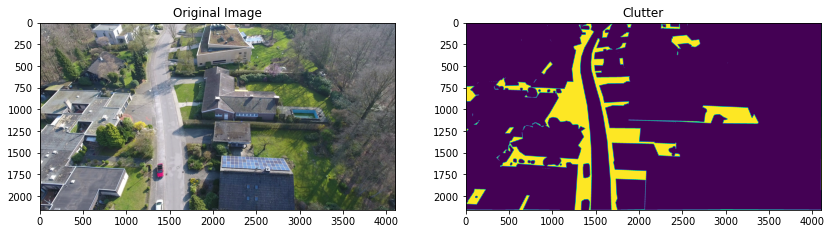

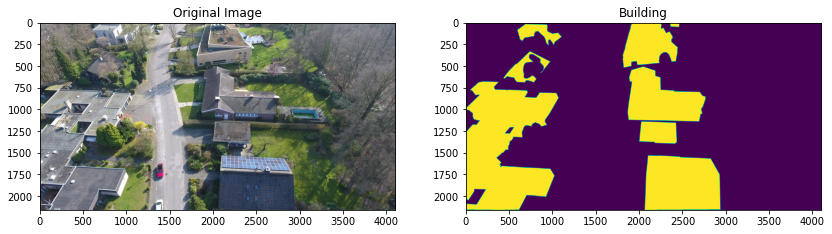

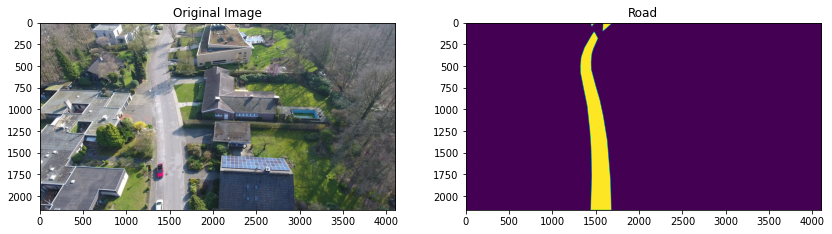

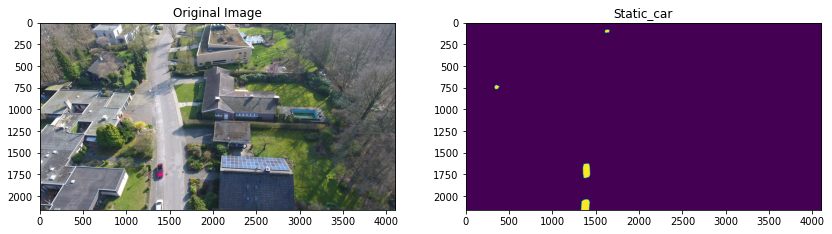

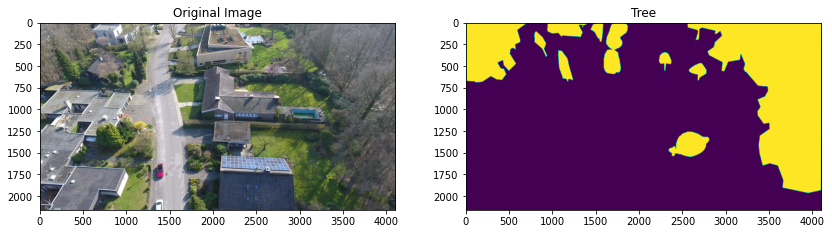

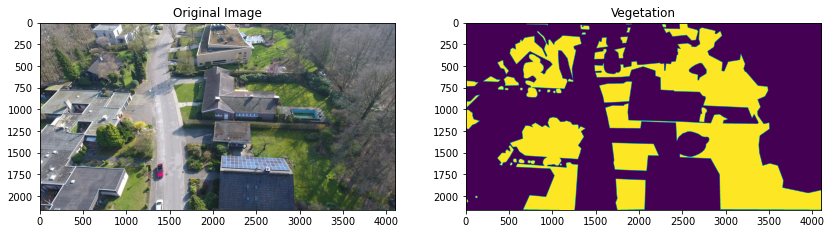

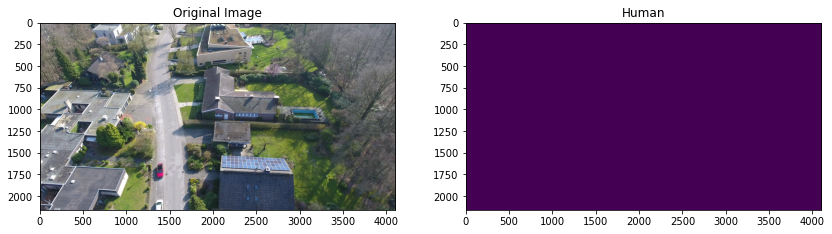

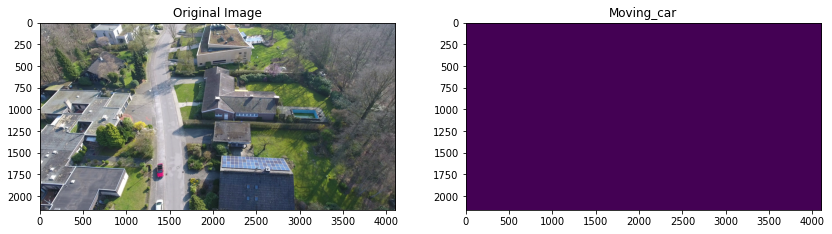

In [ ]:
labels = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
for label in labels:
    dataset = Dataset(train_image_list, train_mask_list, classes=[label])

    image, mask = dataset[4]
    visualize1(
        image=image, mask=mask.squeeze(),
        label = label)

###Apply Augmentations

We'll resize images to 576*1024 to keep 9:16 ratio.

Augmentation list:

    HorizontalFlip
    OneOf(RandomBrightnessContrast, CLAHE, HueSaturationValue)
    IAAAdditiveGaussianNoise with 0.2 probability

Note: For better result we could crop each image into 16 evenly distributed smaller(1280*720) overlapped images that cover the whole image for training.

In [ ]:
#[1]
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.Resize(576, 1024, p=1),
        albu.HorizontalFlip(p=0.5),

        albu.OneOf([
            albu.RandomBrightnessContrast(
                  brightness_limit=0.4, contrast_limit=0.4, p=1),
            albu.CLAHE(p=1),
            albu.HueSaturationValue(p=1)
            ],
            p=0.9,
        ),

        albu.IAAAdditiveGaussianNoise(p=0.2),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.Resize(576, 1024, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
#[1]
#Visualizing augmented images and masks
labels = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
for label in labels:
    augmented_dataset = Dataset(
        train_image_list,
        train_mask_list,
        augmentation=get_training_augmentation(),
        classes=[label],
    )

# same image with different random transforms
    image, mask = augmented_dataset[8]
    visualize1(
        image=image, mask=mask.squeeze(),
        label = label, augment=True)

#Model

##Pre-Trained Segmentation Models

In [ ]:
#[1]
import segmentation_models_pytorch as smp

ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
CLASSES = ['clutter', 'building', 'road', 'static_car', 'tree', 'vegetation', 'human', 'moving_car']
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
seg_model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

seg_preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# # create aerial image model
# gen_model = smp.FPN(
#     encoder_name=ENCODER,
#     encoder_weights=ENCODER_WEIGHTS,
#     classes=len(CLASSES),
#     activation=ACTIVATION,
# )

# gen_preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)



Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

##Discriminator

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
n_epochs=200, # number of epochs of training
batch_size=64, # size of the batches
lr=0.0002, # adam: learning rate
b1=0.5, # adam: decay of first order momentum of gradient
b2=0.999, # adam: decay of first order momentum of gradient
n_cpu=8, # number of cpu threads to use during batch generation
latent_dim=100, # dimensionality of the latent space
num_classes=8, # number of classes for dataset
img_size=32, # size of each image dimension
channels=3, # number of image channels
sample_interval=400, # interval between image s

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, num_classes + 1), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label

In [ ]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize discriminator
discriminator = Discriminator()

TypeError: ignored

In [ ]:
# standard GPU = 1, premium GPU = 6
seg_batch_size = 2

###########
# Segmentation Model
###########

#[1]
seg_train_dataset = Dataset(
    train_image_list,
    train_mask_list,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(seg_preprocessing_fn),
    classes=CLASSES,
)

seg_valid_dataset = Dataset(
    valid_image_list,
    valid_mask_list,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(seg_preprocessing_fn),
    classes=CLASSES,
)

seg_train_loader = DataLoader(seg_train_dataset, batch_size=seg_batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
seg_valid_loader = DataLoader(seg_valid_dataset, batch_size=seg_batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)



# ###########
# # Aerial Image Generator
# ###########

# gen_train_dataset = Dataset(
#     train_mask_list,
#     train_image_list,
#     augmentation=get_training_augmentation(),
#     preprocessing=get_preprocessing(seg_preprocessing_fn),
#     classes=CLASSES,
# )

# gen_valid_dataset = Dataset(
#     valid_mask_list,
#     valid_image_list,
#     augmentation=get_validation_augmentation(),
#     preprocessing=get_preprocessing(seg_preprocessing_fn),
#     classes=CLASSES,
# )

# gen_train_loader = DataLoader(gen_train_dataset, batch_size=seg_batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
# gen_valid_loader = DataLoader(gen_valid_dataset, batch_size=seg_batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)



loaders = {
    "segmentation train": seg_train_loader,
    "segmentation valid": seg_valid_loader,
    # "aerial image train": gen_train_loader,
    # "aerial image valid": gen_valid_loader
}

In [ ]:
###########
# Segmentation Model
###########

#[3]
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

seg_loss = smp.utils.losses.DiceLoss()

seg_optimizer = torch.optim.Adam([
    dict(params=seg_model.parameters(), lr=0.0001),
])

#[4]
#[2]
seg_metrics = [smp.utils.metrics.IoU(threshold=0.5),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[1,2,3,4,5,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,2,3,4,5,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,3,4,5,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,4,5,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,5,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,6,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,5,7]),
              smp.utils.metrics.IoU(threshold=0.5, ignore_channels=[0,1,2,3,4,5,6]),
]

seg_train_epoch = smp.utils.train.TrainEpoch(
    seg_model,
    loss=seg_loss,
    metrics=seg_metrics,
    optimizer=seg_optimizer,
    device=DEVICE,
    verbose=True,
)

seg_valid_epoch = smp.utils.train.ValidEpoch(
    seg_model,
    loss=seg_loss,
    metrics=seg_metrics,
    device=DEVICE,
    verbose=True,
)

seg_train_epoch.metrics[1].__name__="IoU_clutter"
seg_train_epoch.metrics[2].__name__="IoU_building"
seg_train_epoch.metrics[3].__name__="IoU_road"
seg_train_epoch.metrics[4].__name__="IoU_static_car"
seg_train_epoch.metrics[5].__name__="IoU_tree"
seg_train_epoch.metrics[6].__name__="IoU_vegetation"
seg_train_epoch.metrics[7].__name__="IoU_human"
seg_train_epoch.metrics[8].__name__="IoU_moving_car"



# ###########
# # Aerial Image Generator
# ###########

# gen_loss = smp.utils.losses.DiceLoss()

# gen_optimizer = torch.optim.Adam([
#     dict(params=gen_model.parameters(), lr=0.0001),
# ])

# gen_train_epoch = smp.utils.train.TrainEpoch(
#     seg_model,
#     loss=seg_loss,
#     metrics=seg_metrics,
#     optimizer=seg_optimizer,
#     device=DEVICE,
#     verbose=True,
# )

# gen_valid_epoch = smp.utils.train.ValidEpoch(
#     seg_model,
#     loss=seg_loss,
#     metrics=seg_metrics,
#     device=DEVICE,
#     verbose=True,
# )

# gen_train_epoch.metrics[1].__name__="IoU_clutter"
# gen_train_epoch.metrics[2].__name__="IoU_building"
# gen_train_epoch.metrics[3].__name__="IoU_road"
# gen_train_epoch.metrics[4].__name__="IoU_static_car"
# gen_train_epoch.metrics[5].__name__="IoU_tree"
# gen_train_epoch.metrics[6].__name__="IoU_vegetation"
# gen_train_epoch.metrics[7].__name__="IoU_human"
# gen_train_epoch.metrics[8].__name__="IoU_moving_car"



##Training

In [ ]:
# # train model for 40 epochs

# seg_max_score = 0
# gen_max_score = 0

# num_epochs = 2

# for i in range(0, num_epochs):

#     print('\nEpoch: {}'.format(i+1))

#     # train
#     seg_train_logs = seg_train_epoch.run(seg_train_loader)
#     gen_train_logs = gen_train_epoch.run(gen_train_loader)

#     # valid
#     seg_valid_logs = seg_valid_epoch.run(seg_valid_loader)
#     gen_valid_logs = gen_valid_epoch.run(gen_valid_loader)

#     # segmentation save model
#     # do something (save model, change lr, etc.)
#     if seg_max_score < seg_valid_logs['iou_score']:
#         seg_max_score = seg_valid_logs['iou_score']
#         torch.save(seg_model, './best_seg_model.pth')
#         print('Segmentation model saved!')

#     # aerial image save model
#     if gen_max_score < gen_valid_logs['iou_score']:
#         gen_max_score = gen_valid_logs['iou_score']
#         torch.save(gen_model, './best_gen_model.pth')
#         print('Aerial image model saved!')

#     if i == 25:
#         seg_optimizer.param_groups[0]['lr'] = 1e-5
#         gen_optimizer.param_groups[0]['lr'] = 1e-5
#         print('Decreased decoder learning rate to 1e-5!')







# train model for 40 epochs

seg_max_score = 0
# gen_max_score = 0

num_epochs = 2

for epoch in range(0, num_epochs):
    print('\nEpoch: {}'.format(epoch+1))

    # for i, (imgs,)

    # train
    seg_train_logs = seg_train_epoch.run(seg_train_loader)
    # gen_train_logs = gen_train_epoch.run(gen_train_loader)

    # valid
    seg_valid_logs = seg_valid_epoch.run(seg_valid_loader)
    # gen_valid_logs = gen_valid_epoch.run(gen_valid_loader)

    # segmentation save model
    # do something (save model, change lr, etc.)
    if seg_max_score < seg_valid_logs['iou_score']:
        seg_max_score = seg_valid_logs['iou_score']
        torch.save(seg_model, './best_seg_model.pth')
        print('Segmentation model saved!')

    # # aerial image save model
    # if gen_max_score < gen_valid_logs['iou_score']:
    #     gen_max_score = gen_valid_logs['iou_score']
    #     torch.save(gen_model, './best_gen_model.pth')
    #     print('Aerial image model saved!')

    if epoch == 25:
        seg_optimizer.param_groups[0]['lr'] = 1e-5
        # gen_optimizer.param_groups[0]['lr'] = 1e-5
        print('Decreased decoder learning rate to 1e-5!')


Epoch: 1
valid: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it, dice_loss - 0.6486, iou_score - 0.219, IoU_clutter - 0.1732, IoU_building - 0.3104, IoU_road - 0.2006, IoU_static_car - 9.849e-12, IoU_tree - 0.2775, IoU_vegetation - 0.1358, IoU_human - 0.001267, IoU_moving_car - 0.02228]
Segmentation model saved!

Epoch: 2
valid: 100%|██████████| 6/6 [00:07<00:00,  1.26s/it, dice_loss - 0.6096, iou_score - 0.2421, IoU_clutter - 0.177, IoU_building - 0.3303, IoU_road - 0.3674, IoU_static_car - 9.868e-12, IoU_tree - 0.2822, IoU_vegetation - 0.1573, IoU_human - 5.974e-11, IoU_moving_car - 0.008047]
Segmentation model saved!


##Test Best Saved Model

In [ ]:
# load best saved checkpoint
seg_best_model = torch.load('./best_seg_model.pth')
# gen_best_model = torch.load('./best_gen_model.pth')

In [ ]:
#[3]
# evaluate model on val set, as there is no annotated test set
# there is code to create the test dataset object, should you find an annotated test set
seg_test_epoch = smp.utils.train.ValidEpoch(
    model=seg_best_model,
    loss=seg_loss,
    metrics=seg_metrics,
    device=DEVICE,
)

# gen_test_epoch = smp.utils.train.ValidEpoch(
#     model=gen_best_model,
#     loss=gen_loss,
#     metrics=metrics,
#     device=DEVICE,
# )

seg_logs = seg_test_epoch.run(seg_valid_loader)
# gen_logs = gen_test_epoch.run(gen_valid_loader)

valid: 100%|██████████| 6/6 [00:08<00:00,  1.35s/it, dice_loss - 0.6096, iou_score - 0.2421, IoU_clutter - 0.177, IoU_building - 0.3303, IoU_road - 0.3674, IoU_static_car - 9.868e-12, IoU_tree - 0.2822, IoU_vegetation - 0.1573, IoU_human - 5.974e-11, IoU_moving_car - 0.008047]


##Visualize Predictions

In [ ]:
#[3]
# test dataset without transformations for image visualization
seg_valid_dataset_vis = Dataset(
    valid_image_list, valid_mask_list,
    classes=CLASSES,
)

gen_valid_dataset_vis = Dataset(
    valid_mask_list, valid_image_list,
    classes=CLASSES,
)

In [ ]:
#[3]
def combine_masks(masks):
  # masks should be size (channels, w, h)
  output_mask = np.zeros(masks[0].shape, dtype=np.uint8)

  for i, mask in enumerate(masks):
    output_mask[mask==1] = i + 1

  return output_mask

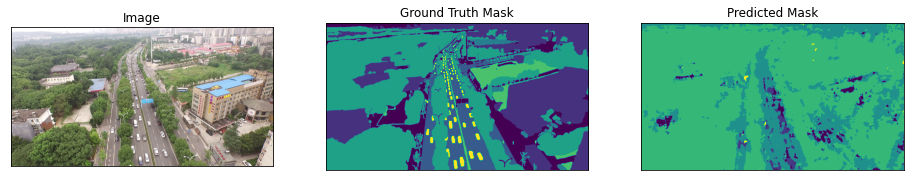

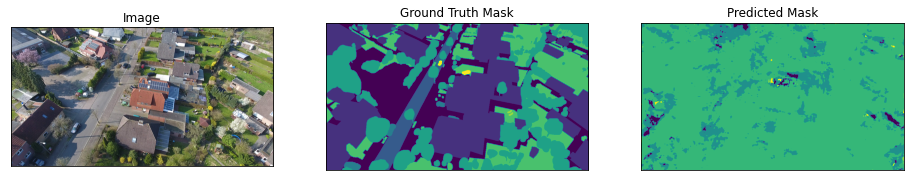

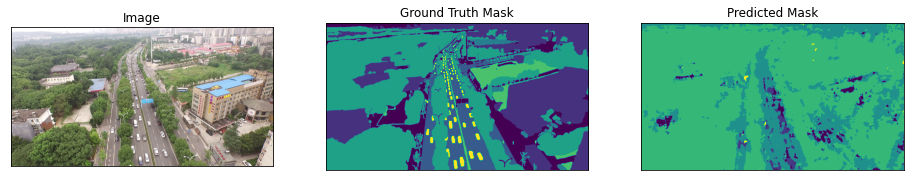

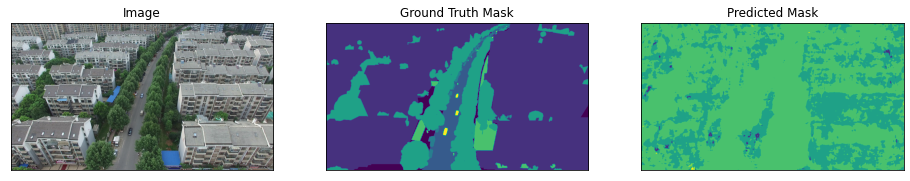

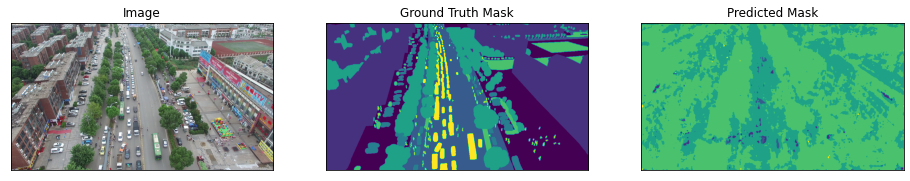

In [ ]:
# segmentation visualization
#[6]

seg_test_dataset = seg_valid_dataset
seg_test_dataset_vis = seg_valid_dataset_vis

for i in range(5):
    n = np.random.choice(len(seg_test_dataset))

    image_vis = seg_test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = seg_test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = seg_best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize2(
        image=image_vis,
        ground_truth_mask=combine_masks(gt_mask),
        predicted_mask=combine_masks(pr_mask)
    )

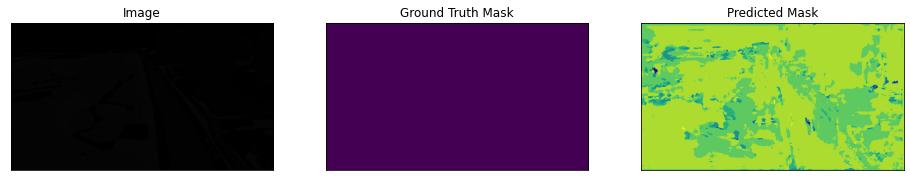

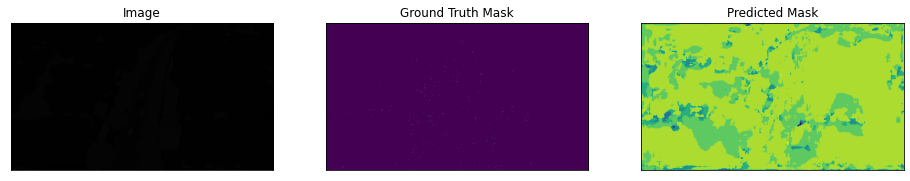

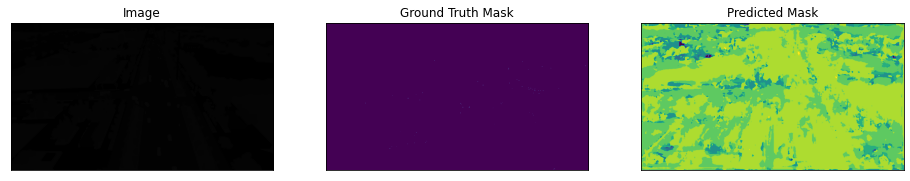

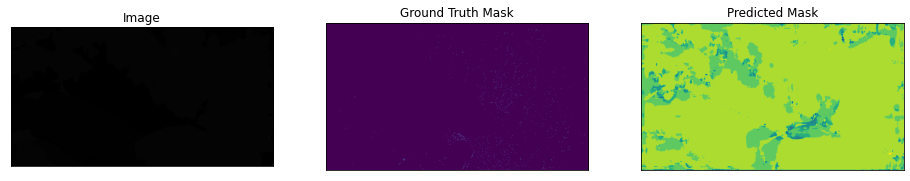

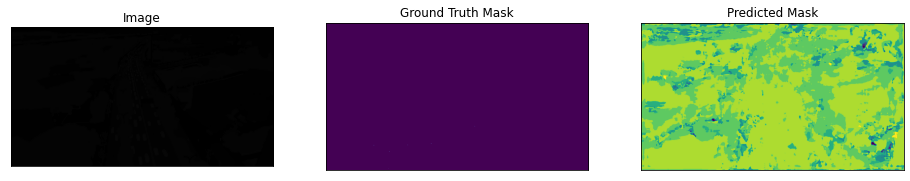

In [ ]:
# # aerial image visualization
# #[6]

# gen_test_dataset = gen_valid_dataset
# gen_test_dataset_vis = gen_valid_dataset_vis

# for i in range(5):
#     n = np.random.choice(len(gen_test_dataset))

#     image_vis = gen_test_dataset_vis[n][0].astype('uint8')
#     image, gt_mask = gen_test_dataset[n]

#     gt_mask = gt_mask.squeeze()

#     x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     pr_mask = gen_best_model.predict(x_tensor)
#     pr_mask = (pr_mask.squeeze().cpu().numpy().round())

#     visualize2(
#         image=image_vis,
#         ground_truth_mask=combine_masks(gt_mask),
#         predicted_mask=combine_masks(pr_mask)
#     )
